In [1]:
"""
this script contains functions to visualize the different attributes
Author: Nathan Greffe
"""
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
from collections import OrderedDict

In [2]:
results = pd.read_csv('architectures.csv')
results = results[np.logical_not(results.acc3.isnull())]
results.reset_index(inplace=True)
results['time'] = results['time'] * 1000
results['error'] = 100*(1.0 - results[['acc1', 'acc2', 'acc3']].mean(axis=1))
results['error_std'] = 100*results[['acc1', 'acc2', 'acc3']].std(axis=1)
results.head()

,index,file_name,arch,depth,width,other,acc1,acc2,acc3,time,error,error_std
0,0,mobilenetv1_d15_cosine,mobilenetv1,15,32,NaN,0.9182,0.9191,0.9196,22.6,8.103333,0.070946
1,4,mobilenetv2_d12_er4_w32_dropout,mobilenetv2,12,32,4.0,0.9440,0.9466,0.9432,262.4,5.540000,0.177764
2,5,mobilenetv2_d12_er4_w16_dropout,mobilenetv2,12,16,4.0,0.9286,0.9312,0.9306,76.1,6.986667,0.136137
3,6,mobilenetv2_d9_er4_w16_dropout,mobilenetv2,9,16,4.0,0.9284,0.9277,0.9305,58.3,7.113333,0.145717
4,7,mobilenetv1_d12_w64_cosine,mobilenetv1,12,64,NaN,0.9351,0.9350,0.9360,52.8,6.463333,0.055076


In [3]:
results_val = pd.read_csv('architectures_val.csv')
results_val['time'] = results_val['time'] * 1000
results_val['error'] = 100*(1.0 - results_val['acc'])
results_val.head()

,file_name,arch,depth,width,other,acc,time,error
0,effnet_d12_e2_cosine,effnet,12,2,NaN,0.8902,10.2,10.98
1,effnet_d12_e3_cosine,effnet,12,32,3.0,0.9038,15.3,9.62
2,effnet_d12_e4_cosine,effnet,12,32,4.0,0.9102,21.5,8.98
3,effnet_d15_e2_cosine,effnet,15,2,NaN,0.8888,10.1,11.12
4,effnet_d15_e3_cosine,effnet,15,32,3.0,0.8964,15.4,10.36


In [4]:
pruning_wrn_res = pd.read_csv('../NetAdapt/pruning_methods.csv')
pruning_wrn_res['table_time'] = pruning_wrn_res['table_time'] * 1000
pruning_wrn_res['measured_time'] = pruning_wrn_res['measured_time'] * 1000
pruning_wrn_res = pruning_wrn_res[np.logical_or(
    pruning_wrn_res.method == 'unpruned',
    np.logical_and(pruning_wrn_res.method == 'fisher_table', 
    pruning_wrn_res.group.isnull()))]  # we take the unpruned + fisher table WRNs
pruning_wrn_res.head()

,file_name,no_fine_tune,fine_tune,retrain_scratch,table_time,measured_time,method,group
39,res-40-2-table_fisher-pf=0.8-150ch,5.28,NaN,4.97,284.2,285.6,fisher_table,NaN
40,res-40-2-table_fisher-pf=0.8-300ch,5.39,NaN,5.25,243.1,240.4,fisher_table,NaN
41,res-40-2-table_fisher-pf=0.8-450ch,5.29,NaN,5.36,220.5,222.0,fisher_table,NaN
42,res-40-2-table_fisher-pf=0.8-600ch,7.52,NaN,5.71,168.6,166.8,fisher_table,NaN
43,res-40-2-table_fisher-pf=0.8-750ch,15.80,NaN,5.92,119.3,117.9,fisher_table,NaN


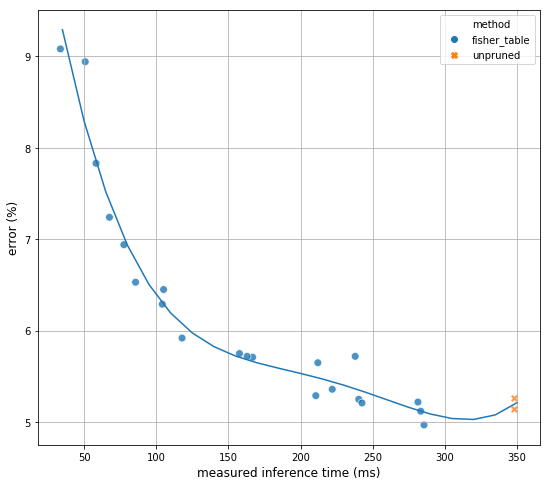

In [5]:
# fits a polynom
polynom = np.poly1d(np.polyfit(pruning_wrn_res.measured_time, 
                               pruning_wrn_res.retrain_scratch, 4))

fig, ax = plt.subplots(1, figsize=(9, 8))
sns.scatterplot(x="measured_time", y="retrain_scratch", data=pruning_wrn_res, hue='method', 
                style='method', legend='brief', ax=ax, s=60, alpha=0.8)
plt.plot(np.arange(35,351,15), polynom(np.arange(35,351,15)))
ax.set_xlabel('measured inference time (ms)', fontsize=12)
ax.set_ylabel('error (%)', fontsize=12)
ax.grid(True)

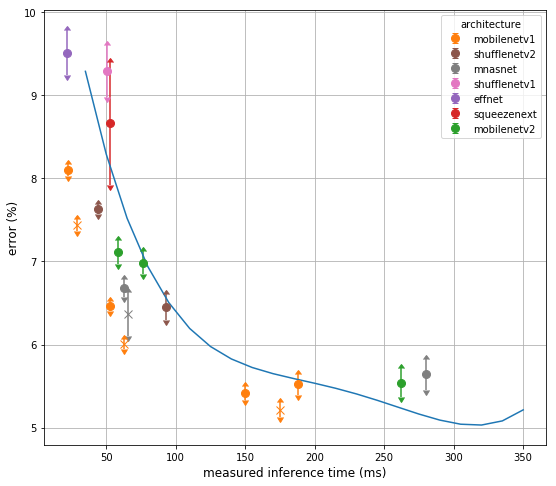

In [9]:
_, idx = np.unique(results.arch, return_index=True)
color_labels = results.arch[np.sort(idx)]
rgb_values = sns.color_palette(n_colors=color_labels.shape[0]+1)[1:]  # skips blue which is 
# already used
color_map = dict(zip(color_labels, rgb_values))
colors = results.arch.map(color_map)

fig, ax = plt.subplots(1, figsize=(9, 8))
plt.plot(np.arange(35,351,15), polynom(np.arange(35,351,15)))
for i in range(results.shape[0]):
    plt.errorbar(results.time[i], 
                 results.error[i],
                 color=colors[i],
                 yerr=results.error_std[i],
                 fmt='x' if 'se' in results.file_name[i] else 'o', 
                 lolims=True, uplims=True,
                 markersize=8, 
                 ecolor=colors[i],
                 label=results.arch[i])
ax.set_xlabel('measured inference time (ms)', fontsize=12)
ax.set_ylabel('error (%)', fontsize=12)
ax.grid(True)

handles, labels = plt.gca().get_legend_handles_labels()  # removes duplicates
by_label = OrderedDict(zip(labels[::-1], handles[::-1]))  # inverted so as to have rounds in 
# the legend
ax.legend(by_label.values(), by_label.keys(), title="architecture");

/home/nathan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


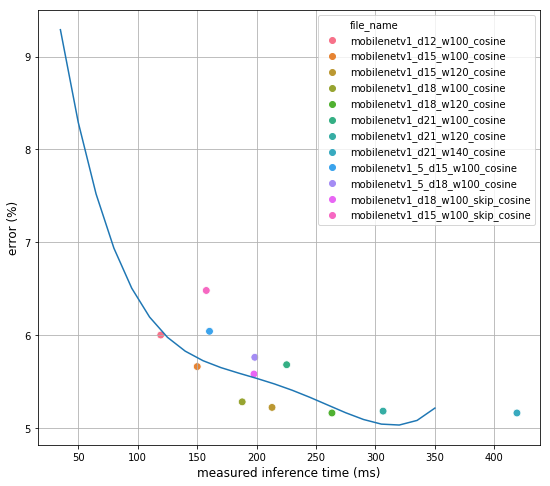

In [21]:
fig, ax = plt.subplots(1, figsize=(9, 8))
results_val_to_plot = results_val[results_val.arch == "mobilenetv1"][results_val.time > 80]
sns.scatterplot(x="time", y="error", data=results_val_to_plot, hue='file_name', 
                legend='brief', ax=ax, s=60)
plt.plot(np.arange(35,351,15), polynom(np.arange(35,351,15)))
ax.set_xlabel('measured inference time (ms)', fontsize=12)
ax.set_ylabel('error (%)', fontsize=12)
ax.grid(True)